In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision import datasets
%matplotlib inline

#Mô hình hoá dữ liệu

In [2]:
#convert dữ liệu vê dạng torch tensor để pytorch xử lý và tính toán
transform = transforms.ToTensor()

#tập dữ liệu traning 
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)

#data loader
#batch_size: số lượng mẫu dữ liệu / batch khi load 
#num_worker=0: dữ liệu được load trong tiến trình chính
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, num_workers=0)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



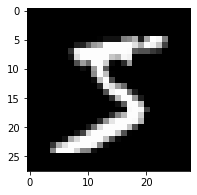

In [3]:
#batch ảnh train 
detaiter = iter(train_loader)
images, labels = detaiter.next()
images = images.numpy()

#lấy một ảnh từ batch 
img = np.squeeze(images[0])

#plot 
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')


#Định nghĩa mô hình
GAN bao gồm hai mạng đối nghịch: discriminator và generator 
##Discriminator
Mạng D là bộ phân loại tuyến tính. Cần ít nhất một lớp ẩn với một thuộc tính chính (key attribute) để xấp xỉ universal function


> Các lớp ẩn có hàm kích hoạt Leaky Relu áp dụng cho output:         

![picture](https://drive.google.com/uc?export=view&id=1mqisUJmhbHupH4kX2VUbo1HVRc6MOsK2)

### Leaky Relu
Hàm leaky Relu tương tự như hàm ReLU nhưng nó thay thế phần âm của ReLU bằng hàm tuyến tính với hệ số góc nhỏ cố định.
![picture](https://drive.google.com/uc?export=view&id=1Czk8QuQ1lVQXikaqVY6-TVk6M-6jeftY)

### Sigmoid Output
Giá trị ouput của D là 0 - 1 để nhận biết ảnh giả và ảnh thật


> BCEWithLogisLoss kết hợp hàm kích hoạt sigmoid và binary cross entropy loss trong một hàm





In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size):
    super(Discriminator, self).__init__()     #chu y 

    #định nghĩa hidden linear layers
    self.fc1 = nn.Linear(input_size, hidden_dim * 4)

    print("self.fc1: ", self.fc1)

    self.fc2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
    self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim)
    self.fc4 = nn.Linear(hidden_dim, output_size)

    #dropout để bỏ một số nút mạng để tránh over-fitting 
    self.dropout = nn.Dropout(p=0.3)

  def forward(self, x):
    #sau khi sử dụng các lớp tích chập để trích xuất được các đặc trưng của ảnh thì 
    #vẫn qua 1 lớp flatten để trải phẳng ma trận 2 chiều thành vector 1 chiều
    x = x.view(-1, 28*28)

    #tất cả hidden layers
    x = F.leaky_relu(self.fc1(x), 0.2)
    x = self.dropout(x)

    x = F.leaky_relu(self.fc2(x), 0.2)
    x = self.dropout(x)

    x = F.leaky_relu(self.fc3(x), 0.2)
    x = self.dropout(x)

    #final layer
    out = self.fc4(x)

    return out

Trong đó fc1, fc2, fc3 là các fully connected layers. Các feature được truyền qua bắt đầu từ fc1 đến fc4.
Hàm forward dùng leaky_relu để phi tuyến tính hoá output đầu ra


##Generator
Mạng G gần tương tự như D nhưng có thêm hàm kích hoạt tanh ở layer output

Hàm tanh nhận đầu vào là số thực và đầu ra là khoảng (-1; 1) 
![picture](https://drive.google.com/uc?export=view&id=1ivCurjNi2xlMlobZBH47iMZCDJyICMc_)



In [5]:
class Generator(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size):
    super(Generator, self).__init__()

    self.fc1 = nn.Linear(input_size, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
    self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim * 4)
    self. fc4 = nn.Linear(hidden_dim * 4, output_size)

    self.dropout = nn.Dropout(0.3)

  def forward(self, x):
    x = F.leaky_relu(self.fc1(x), 0.2)
    x = self.dropout(x)

    x = F.leaky_relu(self.fc2(x), 0.2)
    x = self.dropout(x)

    x = F.leaky_relu(self.fc3(x), 0.2)
    x = self.dropout(x)

    #hàm tạnh cho final layer
    out = F.tanh(self.fc4(x))

    return out

##Model hyperparameters
Các hyperparameter dùng để train GAN:     


In [6]:
# Discriminator hyperparams

# Kích thước ảnh input discriminator (28*28)
input_size = 784
# Kích thước ảnh output discriminator (real or fake)
d_output_size = 1
# Kích thước last hidden layer discriminator
d_hidden_size = 32

# Generator hyperparams

# Kích thước latent vector của generator
z_size = 100
# Kích thước discriminator output (generated image)
g_output_size = 784
# Kích thước first hidden layer của generator
g_hidden_size = 32


#Khởi tạo mô hình hoàn chỉnh


In [7]:
# khởi tạo discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

print(D)
print()
print(G)

self.fc1:  Linear(in_features=784, out_features=128, bias=True)
Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


#Hàm loss của Discriminator và Generator

In [8]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # real labels = 0.9
        labels = torch.ones(batch_size) * 0.9
    else: #not smooth
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # Tính hàm loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

#Thuật toán tối ưu
Cập nhật tham số D và G dùng thuật toán Adam 


In [9]:
import torch.optim as optim

lr = 0.002

d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

#Training
##Discriminator training

1.   Tính hàm loss của D với ảnh thật (training) 
2.   G sinh ảnh giả
3. Tính hàm loss của D với ảnh giả (ảnh do G sinh ra)
4. Cộng hai hàm loss với nhau
5. Thực hiện lan truyền ngược và áo dụng thuật toán tối ưu để update D's weights

##Generator training


1.   G sinh ảnh giả
2.   Tính hàm loss của D với ảnh giả 
3. Thực hiện lan truyền ngược và áp dụng thuật toán tối ưu để update G's weights

In [10]:
import pickle as pkl

numberOfEpochs = 200

samples = []
losses = []           #giá trị loss

sample_size = 16
fixed_z = np.random.uniform(-1, 1, size = (sample_size, z_size))   #(16, 100)
fixed_z = torch.from_numpy(fixed_z).float()

D.train()
G.train()

i = 0

for epoch in range(numberOfEpochs):
  for batch_i, (real_images, _) in enumerate(train_loader):
    i += 1
    batch_size = real_images.size(0)
    real_images = real_images * 2 - 1 #rescale input [0, 1) -> [-1, 1)
    
    #Train D

    d_optimizer.zero_grad()

    #1. train với ảnh thực
    D_real = D(real_images)
    d_real_loss = real_loss(D_real, smooth = True)    #giá trị hàm loss với ảnh thật 

    #2. Train với ảnh giả
    with torch.no_grad():
      z = np.random.uniform(-1, 1, size = (batch_size, z_size))
      z = torch.from_numpy(z).float()
      fake_images = G(z)

    #tính hàm loss của D với ảnh giả
    D_fake = D(fake_images)
    d_fake_loss = fake_loss(D_fake)

    #cộng hai hàm loss và lan truyền ngược
    d_loss = d_real_loss + d_fake_loss
    d_loss.backward()
    d_optimizer.step()

    #TRAIN G

    g_optimizer.zero_grad()

    #1. train với ảnh giả

    #G sinh ảnh giả
    z = np.random.uniform(-1, 1, size = (batch_size, z_size))
    z = torch.from_numpy(z).float()
    fake_images = G(z)

    #tính hàm loss G trong tập ảnh giả dùng flipped labels
    D_fake = D(fake_images)
    g_loss = real_loss(D_fake)

    #lan truyền ngược
    g_loss.backward()
    g_optimizer.step()

    #in giá trị loss
    if batch_i % 400 == 0:
      print('Epoch[{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(epoch + 1, numberOfEpochs, d_loss.item(), g_loss.item()))

  #sau mỗi epoch
  #append D loss và G loss 
  losses.append((d_loss.item(), g_loss.item()))
  G.eval()
  sample_z = G(fixed_z)
  samples.append(sample_z)
  G.train()   #train G

print("số vòng lặp train của D: ", i)

with open('train_samples.pkl', 'wb') as f:
  pkl.dump(samples, f)



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch[    1/  200] | d_loss: 1.3666 | g_loss: 0.7087
Epoch[    1/  200] | d_loss: 1.0116 | g_loss: 6.0410
Epoch[    1/  200] | d_loss: 0.9269 | g_loss: 2.8358
Epoch[    2/  200] | d_loss: 1.0424 | g_loss: 1.9189
Epoch[    2/  200] | d_loss: 1.2870 | g_loss: 1.3953
Epoch[    2/  200] | d_loss: 0.9630 | g_loss: 2.5308
Epoch[    3/  200] | d_loss: 1.4152 | g_loss: 0.7279
Epoch[    3/  200] | d_loss: 0.8120 | g_loss: 1.8588
Epoch[    3/  200] | d_loss: 0.8896 | g_loss: 3.1977
Epoch[    4/  200] | d_loss: 0.8379 | g_loss: 2.3595
Epoch[    4/  200] | d_loss: 1.2059 | g_loss: 1.5030
Epoch[    4/  200] | d_loss: 1.0179 | g_loss: 1.2435
Epoch[    5/  200] | d_loss: 1.2769 | g_loss: 0.9085
Epoch[    5/  200] | d_loss: 1.0363 | g_loss: 1.7818
Epoch[    5/  200] | d_loss: 1.3653 | g_loss: 1.1478
Epoch[    6/  200] | d_loss: 1.2591 | g_loss: 2.2262
Epoch[    6/  200] | d_loss: 1.2566 | g_loss: 0.9541
Epoch[    6/  200] | d_loss: 1.2835 | g_loss: 2.1921
Epoch[    7/  200] | d_loss: 1.0071 | g_loss: 

#Training loss
Biểu đồ thể hiện giá trị hàm loss của G và D sau mỗi epoch
;    

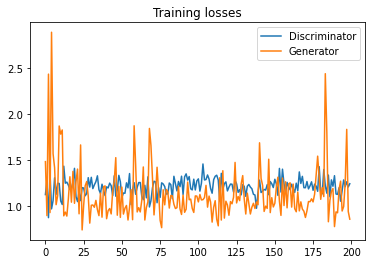

In [11]:
figure = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label = "Discriminator")
plt.plot(losses.T[1], label = "Generator")
plt.title("Training losses")
plt.legend()


#Ảnh Generator sinh ra trong training


In [12]:
def view_sample(epoch, samples):
  figure, axes = plt.subplots(figsize = (7, 7), nrows = 4, ncols = 4, sharey=True, sharex=True)
  for ax, img in zip(axes.flatten(), samples[epoch]):
    img = img.detach()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img.reshape((28, 28)), cmap='Greys_r')

#lấy mẫu từ G trong quá trình training
with open('train_samples.pkl', 'rb') as f:
  samples = pkl.load(f)

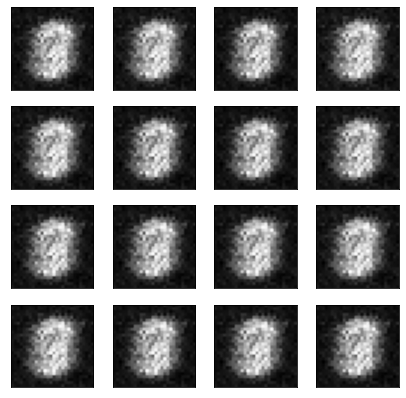

In [13]:
#Ảnh sau epoch đầu
view_sample(0, samples)

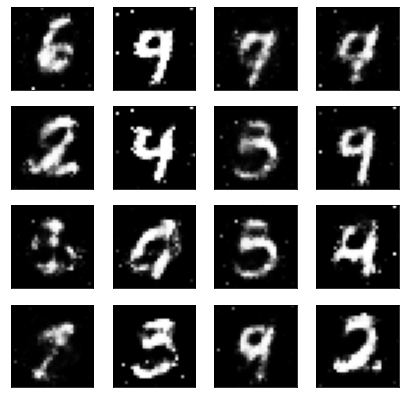

In [14]:
#Ảnh sau epoch cuối
view_sample(199, samples)

Ảnh sinh ra từ G trong quá trình training, mỗi 10 epoch


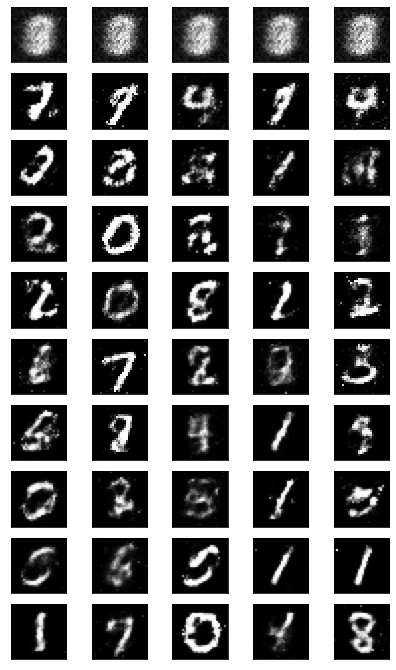

In [15]:
fig, axes = plt.subplots(figsize = (7, 12), nrows = 10, ncols = 5, sharex = True, sharey = True)
for sample, ax_row in zip(samples[::int(len(samples)/10)], axes):
  for img, ax in zip(sample[: : int(len(sample)/6)], ax_row):
    image = img.detach()
    ax.imshow(image.reshape((28, 28)), cmap = 'Greys_r')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)


#Mẫu ảnh từ Generator

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


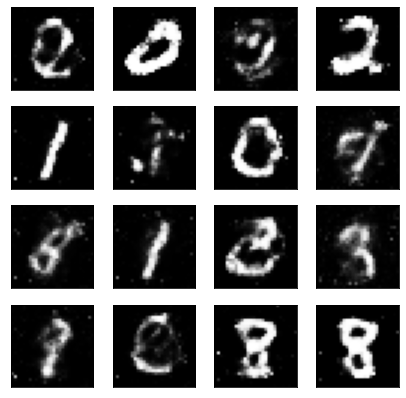

In [16]:
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval()

rand_images = G(rand_z)

view_sample(0, [rand_images])